# Odds and Addends

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.6.8-py3-none-any.whl size=12125 sha256=1e444207647cb9f1b16c5364a0f66aa2b0190c37d55c6a5e239705c883928964
  Stored in directory: /root/.cache/pip/wheels/c2/3f/cf/74b5adbcea4efaae43ce168e622e3eb8dbc1251d5d730dd245
Successfully built empiricaldist


In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

Downloaded utils.py


In [3]:
from utils import set_pyplot_params
set_pyplot_params()

This chapter presents a new way to represent a degree of certainty, **odds**, and a new form of Bayes's Theorem, called **Bayes's Rule**.
Bayes's Rule is convenient if you want to do a Bayesian update on paper or in your head.
It also sheds light on the important idea of **evidence** and how we can quantify the strength of evidence.

The second part of the chapter is about "addends", that is, quantities being added, and how we can compute their distributions.
We'll define functions that compute the distribution of sums, differences, products, and other operations.
Then we'll use those distributions as part of a Bayesian update.

## Odds

One way to represent a probability is with a number between 0 and 1, but that's not the only way.
If you have ever bet on a football game or a horse race, you have probably encountered another representation of probability, called **odds**.

You might have heard expressions like "the odds are three to one", but you might not know what that means.
The **odds in favor** of an event are the ratio of the probability
it will occur to the probability that it will not.

The following function does this calculation.

In [4]:
def odds(p):
    return p / (1-p)

For example, if my team has a 75% chance of winning, the odds in their favor are three to one, because the chance of winning is three times the chance of losing.

In [5]:
odds(0.75)

3.0

You can write odds in decimal form, but it is also common to
write them as a ratio of integers.
So "three to one" is sometimes written $3:1$.

When probabilities are low, it is more common to report the
**odds against** rather than the odds in favor.
For example, if my horse has a 10% chance of winning, the odds in favor are $1:9$.

In [6]:
odds(0.1)

0.11111111111111112

But in that case it would be more common I to say that the odds against are $9:1$.

In [7]:
odds(0.9)

9.000000000000002

Given the odds in favor, in decimal form, you can convert to probability like this:

In [8]:
def prob(o):
    return o / (o+1)

For example, if the odds are $3/2$, the corresponding probability is $3/5$:

In [9]:
prob(3/2)

0.6

Or if you represent odds with a numerator and denominator, you can convert to probability like this:

In [10]:
def prob2(yes, no):
    return yes / (yes + no)

In [11]:
prob2(3, 2)

0.6

Probabilities and odds are different representations of the
same information; given either one, you can compute the other.
But some computations are easier when we work with odds, as we'll see in the next section, and some computations are even easier with log odds, which we'll see later.

## Bayes's Rule

So far we have worked with Bayes's theorem in the "probability form": 

$$P(H|D) = \frac{P(H)~P(D|H)}{P(D)}$$

Writing $\mathrm{odds}(A)$ for odds in favor of $A$, we can express Bayes's Theorem in "odds form":

$$\mathrm{odds}(A|D) = \mathrm{odds}(A)~\frac{P(D|A)}{P(D|B)}$$

This is Bayes's Rule, which says that the posterior odds are the prior odds times the likelihood ratio.
Bayes's Rule is convenient for computing a Bayesian update on paper or in your head. For example, let's go back to the cookie problem:

> Suppose there are two bowls of cookies. Bowl 1 contains 30 vanilla cookies and 10 chocolate cookies. Bowl 2 contains 20 of each. Now suppose you choose one of the bowls at random and, without looking, select a cookie at random. The cookie is vanilla. What is the probability that it came from Bowl 1?

The prior probability is 50%, so the prior odds are 1. The likelihood ratio is $\frac{3}{4} / \frac{1}{2}$, or $3/2$. So the posterior odds are $3/2$, which corresponds to probability $3/5$.

In [12]:
prior_odds = 1
likelihood_ratio = (3/4) / (1/2)
post_odds = prior_odds * likelihood_ratio
post_odds

1.5

In [13]:
post_prob = prob(post_odds)
post_prob

0.6

If we draw another cookie and it's chocolate, we can do another update:

In [14]:
likelihood_ratio = (1/4) / (1/2)
post_odds *= likelihood_ratio
post_odds

0.75

And convert back to probability.

In [15]:
post_prob = prob(post_odds)
post_prob

0.42857142857142855

## Oliver's Blood

I’ll use Bayes’s Rule to solve another problem from MacKay’s
[*Information Theory, Inference, and Learning Algorithms*](https://www.inference.org.uk/mackay/itila/):

> Two people have left traces of their own blood at the scene of a crime. A suspect, Oliver, is tested and found to have type ‘O’ blood. The blood groups of the two traces are found to be of type ‘O’ (a common type in the local population, having frequency 60%) and of type ‘AB’ (a rare type, with frequency 1%). Do these data \[the traces found at the scene\] give evidence in favor of the proposition that Oliver was one of the people \[who left blood at the scene\]?

To answer this question, we need to think about what it means for data
to give evidence in favor of (or against) a hypothesis. Intuitively, we might say that data favor a hypothesis if the hypothesis is more likely in light of the data than it was before.

In the cookie problem, the prior odds are 1, which corresponds to probability 50%. The posterior odds are $3/2$, or probability 60%. So the vanilla cookie is evidence in favor of Bowl 1.

Bayes's Rule provides a way to make this intuition more precise. Again

$$\mathrm{odds}(A|D) = \mathrm{odds}(A)~\frac{P(D|A)}{P(D|B)}$$

Dividing through by $\mathrm{odds}(A)$, we get: 

$$\frac{\mathrm{odds}(A|D)}{\mathrm{odds}(A)} = \frac{P(D|A)}{P(D|B)}$$

The term on the left is the ratio of the posterior and prior odds. The term on the right is the likelihood ratio, also called the **Bayes
factor**.

If the Bayes factor is greater than 1, that means that the data were
more likely under $A$ than under $B$. And that means that the odds are
greater, in light of the data, than they were before.

If the Bayes factor is less than 1, that means the data were less likely under $A$ than under $B$, so the odds in favor of $A$ go down.

Finally, if the Bayes factor is exactly 1, the data are equally likely
under either hypothesis, so the odds do not change.

Let's apply that to the problem at hand. If Oliver is one of the people who left blood at the crime scene, he accounts for the ‘O’ sample; in that case, the probability of the data is the probability that a random member of the population has type ‘AB’ blood, which is 1%.

If Oliver did not leave blood at the scene, we have two samples to
account for. 
If we choose two random people from the population, what is the chance of finding one with type ‘O’ and one with type ‘AB’? 
Well, there are two ways it might happen: 

* The first person might have ‘O’ and the second ‘AB’, 

* Or the first person might have ‘AB’ and the second ‘O’.

The probability of either combination is $(0.6) (0.01)$, which is 0.6%, so the total probability is twice that, or 1.2%.
So the data are a little more likely if Oliver is *not* one of the people who left blood at the scene.

We can use these probabilities to compute the likelihood ratio:

In [16]:
like1 = 0.01
like2 = 2 * 0.6 * 0.01

likelihood_ratio = like1 / like2
likelihood_ratio

0.8333333333333334

Since the likelihood ratio is less than 1, the blood tests are evidence *against* the hypothesis that Oliver left blood at the scence.

But it is weak evidence.  For example, if the prior odds were 1 (that is, 50% probability), the posterior odds would be 0.83, which corresponds to a probability of 45%:

In [17]:
post_odds = 1 * like1 / like2
prob(post_odds)

0.45454545454545453

So this evidence doesn't "move the needle" very much.

This example is a little contrived, but it demonstrates the
counterintuitive result that data *consistent* with a hypothesis are
not necessarily *in favor of* the hypothesis.

If this result still bothers you, this way of thinking might help: the
data consist of a common event, type ‘O’ blood, and a rare event, type
‘AB’ blood. If Oliver accounts for the common event, that leaves the
rare event unexplained. If Oliver doesn’t account for the ‘O’ blood, we
have two chances to find someone in the population with ‘AB’ blood. And
that factor of two makes the difference.

**Exercise:** Suppose that based on other evidence, you prior belief in Oliver's guilt is 90%.  How much would the blood evidence in this section change your beliefs?  What if you initially thought there was only a 10% chance of his guilt?

In [18]:
# Solution goes here
post_odds = odds(0.9) * like1 / like2
prob(post_odds)

0.8823529411764706

In [19]:
# Solution goes here

post_odds = odds(0.1) * like1 / like2
prob(post_odds)

0.0847457627118644

## Addends

The second half of this chapter is about distributions of sums and results of other operations.
We'll start with a forward problem, where we are given the inputs and compute the distribution of the output.
Then we'll work on inverse problems, where we are given the outputs and we compute the distribution of the inputs.

As a first example, suppose you roll two dice and add them up. What is the distribution of the sum? 
I’ll use the following function to create a `Pmf` that represents the
possible outcomes of a die:

In [20]:
import numpy as np
from empiricaldist import Pmf

def make_die(sides):
    outcomes = np.arange(1, sides+1)
    die = Pmf(1/sides, outcomes)
    return die

On a six-sided die, the outcomes are 1 through 6, all
equally likely.

In [21]:
die = make_die(6)

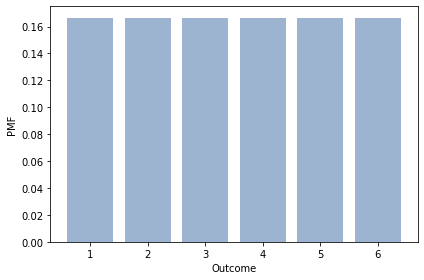

In [22]:
from utils import decorate

die.bar(alpha=0.4)
decorate(xlabel='Outcome',
         ylabel='PMF')

If we roll two dice and add them up, there are 11 possible outcomes, 2
through 12, but they are not equally likely. To compute the distribution
of the sum, we have to enumerate the possible outcomes. 

And that's how this function works:

In [23]:
def add_dist(pmf1, pmf2):
    """Compute the distribution of a sum."""
    res = Pmf()
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            q = q1 + q2
            p = p1 * p2
            res[q] = res(q) + p
    return res

The parameters are `Pmf` objects representing distributions.

The loops iterate though the quantities and probabilities in the `Pmf` objects.
Each time through the loop `q` gets the sum of a pair of quantities, and `p` gets the probability of the pair.
Because the same sum might appear more than once, we have to add up the total probability for each sum.

Notice a subtle element of this line:

```
            res[q] = res(q) + p
```

I use parentheses on the right side of the assignment, which returns 0 if `q` does not appear yet in `res`.
I use brackets on the left side of the assignment to create or update an element in `res`; using parentheses on the left side would not work.

`Pmf` provides `add_dist`, which does the same thing.
You can call it as a method, like this:

In [24]:
twice = die.add_dist(die)

Or as a function, like this:

In [25]:
twice = Pmf.add_dist(die, die)

And here's what the result looks like:

In [26]:
from utils import decorate

def decorate_dice(title=''):
    decorate(xlabel='Outcome',
             ylabel='PMF',
             title=title)

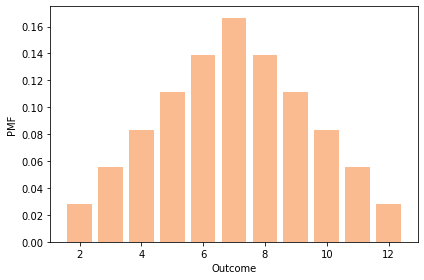

In [27]:
twice = add_dist(die, die)
twice.bar(color='C1', alpha=0.5)
decorate_dice()

If we have a sequence of `Pmf` objects that represent dice, we can compute the distribution of the sum like this:


In [28]:
def add_dist_seq(seq):
    """Compute Pmf of the sum of values from seq."""
    total = seq[0]
    for other in seq[1:]:
        total = total.add_dist(other)
    return total

As an example, we can make a list of three dice like this:

In [29]:
dice = [die] * 3

And we can compute the distribution of their sum like this.

In [30]:
thrice = add_dist_seq(dice)

The following figure shows what these three distributions look like:

-   The distribution of a single die is uniform from 1 to 6.

-   The sum of two dice has a triangle distribution between 2 and 12.

-   The sum of three dice has a bell-shaped distribution between 3
    and 18.

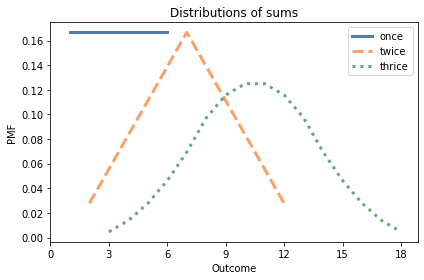

In [31]:
import matplotlib.pyplot as plt

die.plot(label='once')
twice.plot(label='twice', ls='--')
thrice.plot(label='thrice', ls=':')

plt.xticks([0,3,6,9,12,15,18])
decorate_dice(title='Distributions of sums')

As an aside, this example demonstrates the Central Limit Theorem, which says that the distribution of a sum converges on a bell-shaped normal distribution, at least under some conditions.

## Gluten Sensitivity

In 2015 I read a paper that tested whether people diagnosed with gluten sensitivity (but not celiac disease) were able to distinguish gluten flour from non-gluten flour in a blind challenge
([you can read the paper here](https://onlinelibrary.wiley.com/doi/full/10.1111/apt.13372)).

Out of 35 subjects, 12 correctly identified the gluten flour based on
resumption of symptoms while they were eating it. Another 17 wrongly
identified the gluten-free flour based on their symptoms, and 6 were
unable to distinguish.

The authors conclude, "Double-blind gluten challenge induces symptom
recurrence in just one-third of patients."

This conclusion seems odd to me, because if none of the patients were
sensitive to gluten, we would expect some of them to identify the gluten flour by chance. 
So here's the question: based on this data, how many of the subjects are sensitive to gluten and how many are guessing?

We can use Bayes's Theorem to answer this question, but first we have to make some modeling decisions. I'll assume:

-   People who are sensitive to gluten have a 95% chance of correctly
    identifying gluten flour under the challenge conditions, and

-   People who are not sensitive have a 40% chance of identifying the
    gluten flour by chance (and a 60% chance of either choosing the
    other flour or failing to distinguish).

These particular values are arbitrary, but the results are not sensitive to these choices.

I will solve this problem in two steps. First, assuming that we know how many subjects are sensitive, I will compute the distribution of the data. 
Then, using the likelihood of the data, I will compute the posterior distribution of the number of sensitive patients.

The first is the **forward problem**; the second is the **inverse
problem**.

## The Forward Problem

Suppose we know that 10 of the 35 subjects are sensitive to gluten. That
means that 25 are not:

In [32]:
n = 35
num_sensitive = 10
num_insensitive = n - num_sensitive

Each sensitive subject has a 95% chance of identifying the gluten flour,
so the number of correct identifications follows a binomial distribution.

I'll use `make_binomial`, which we defined in <<_TheBinomialDistribution>>, to make a `Pmf` that represents the binomial distribution.

In [33]:
from utils import make_binomial

dist_sensitive = make_binomial(num_sensitive, 0.95)
dist_insensitive = make_binomial(num_insensitive, 0.40)

The results are the distributions for the number of correct identifications in each group.

Now we can use `add_dist` to compute the distribution of the total number of correct identifications:

In [34]:
dist_total = Pmf.add_dist(dist_sensitive, dist_insensitive)

Here are the results:

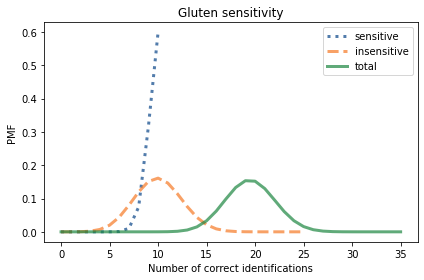

In [35]:
dist_sensitive.plot(label='sensitive', ls=':')
dist_insensitive.plot(label='insensitive', ls='--')
dist_total.plot(label='total')

decorate(xlabel='Number of correct identifications',
         ylabel='PMF',
         title='Gluten sensitivity')

We expect most of the sensitive subjects to identify the gluten flour correctly.
Of the 25 insensitive subjects, we expect about 10 to identify the gluten flour by chance.
So we expect about 20 correct identifications in total.

This is the answer to the forward problem: given the number of sensitive subjects, we can compute the distribution of the data.

## The Inverse Problem

Now let's solve the inverse problem: given the data, we'll compute the posterior distribution of the number of sensitive subjects.

Here's how.  I'll loop through the possible values of `num_sensitive` and compute the distribution of the data for each:

In [36]:
import pandas as pd

table = pd.DataFrame()
for num_sensitive in range(0, n+1):
    num_insensitive = n - num_sensitive
    dist_sensitive = make_binomial(num_sensitive, 0.95)
    dist_insensitive = make_binomial(num_insensitive, 0.4)
    dist_total = Pmf.add_dist(dist_sensitive, dist_insensitive)    
    table[num_sensitive] = dist_total

The loop enumerates the possible values of `num_sensitive`.
For each value, it computes the distribution of the total number of correct identifications, and stores the result as a column in a Pandas `DataFrame`.

In [37]:
table.head(3)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.719071e-08,1.432559e-09,1.193799e-10,9.948326e-12,8.290272e-13,6.908560e-14,5.757133e-15,4.797611e-16,3.998009e-17,3.331674e-18,...,1.501694e-36,1.251411e-37,1.042843e-38,8.690357e-40,7.241964e-41,6.034970e-42,5.029142e-43,4.190952e-44,3.492460e-45,2.910383e-46
1,4.011165e-07,5.968996e-08,7.162795e-09,7.792856e-10,8.013930e-11,7.944844e-12,7.676178e-13,7.276377e-14,6.796616e-15,6.274653e-16,...,7.508469e-34,6.486483e-35,5.596590e-36,4.823148e-37,4.152060e-38,3.570691e-39,3.067777e-40,2.633315e-41,2.258457e-42,1.935405e-43
2,4.545987e-06,9.741401e-07,1.709122e-07,2.506426e-08,3.269131e-09,3.940182e-10,4.490244e-11,4.908756e-12,5.197412e-13,5.365476e-14,...,1.806613e-31,1.620070e-32,1.449030e-33,1.292922e-34,1.151034e-35,1.022555e-36,9.066202e-38,8.023344e-39,7.088005e-40,6.251357e-41


The following figure shows selected columns from the `DataFrame`, corresponding to different hypothetical values of `num_sensitive`:

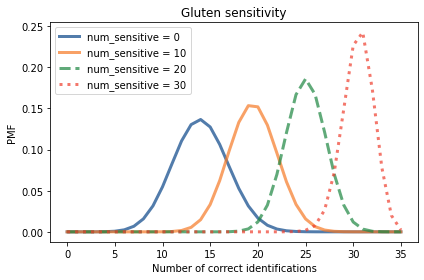

In [38]:
table[0].plot(label='num_sensitive = 0')
table[10].plot(label='num_sensitive = 10')
table[20].plot(label='num_sensitive = 20', ls='--')
table[30].plot(label='num_sensitive = 30', ls=':')
    
decorate(xlabel='Number of correct identifications',
         ylabel='PMF',
         title='Gluten sensitivity')

Now we can use this table to compute the likelihood of the data:

In [39]:
likelihood1 = table.loc[12]

`loc` selects a row from the `DataFrame`.
The row with index 12 contains the probability of 12 correct identifications for each hypothetical value of `num_sensitive`.
And that's exactly the likelihood we need to do a Bayesian update.

I'll use a uniform prior, which implies that I would be equally surprised by any value of `num_sensitive`:

In [40]:
hypos = np.arange(n+1)
prior = Pmf(1, hypos)

And here's the update:


In [41]:
posterior1 = prior * likelihood1
posterior1.normalize()

0.4754741648615132

For comparison, I also compute the posterior for another possible outcome, 20 correct identifications.

In [42]:
likelihood2 = table.loc[20]
posterior2 = prior * likelihood2
posterior2.normalize()

1.7818649765887375

The following figure shows posterior distributions of `num_sensitive` based on the actual data, 12 correct identifications, and the other possible outcome, 20 correct identifications.

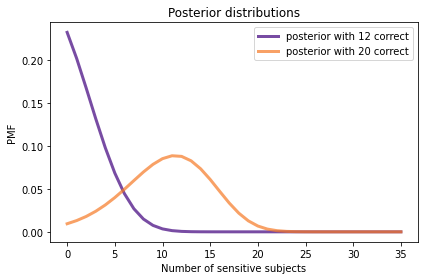

In [43]:
posterior1.plot(label='posterior with 12 correct', color='C4')
posterior2.plot(label='posterior with 20 correct', color='C1')

decorate(xlabel='Number of sensitive subjects',
         ylabel='PMF',
         title='Posterior distributions')

With 12 correct identifications, the most likely conclusion is that none of the subjects are sensitive to gluten.
If there had been 20 correct identifications, the most likely conclusion would be that 11-12 of the subjects were sensitive.

In [44]:
posterior1.max_prob()

0

In [45]:
posterior2.max_prob()

11

## Summary

This chapter presents two topics that are almost unrelated except that they make the title of the chapter catchy.

The first part of the chapter is about Bayes's Rule, evidence, and how we can quantify the strength of evidence using a likelihood ratio or Bayes factor.

The second part is about `add_dist`, which computes the distribution of a sum.
We can use this function to solve forward and inverse problems; that is, given the parameters of a system, we can compute the distribution of the data or, given the data, we can compute the distribution of the parameters.

In the next chapter, we'll compute distributions for minimums and maximums, and use them to solve more Bayesian problems.
But first you might want to work on these exercises.

## Exercises

**Exercise:** Let's use Bayes's Rule to solve the Elvis problem from <<_Distributions>>:

> Elvis Presley had a twin brother who died at birth. What is the probability that Elvis was an identical twin?

In 1935, about 2/3 of twins were fraternal and 1/3 were identical.
The question contains two pieces of information we can use to update this prior.

* First, Elvis's twin was also male, which is more likely if they were identical twins, with a likelihood ratio of 2.

* Also, Elvis's twin died at birth, which is more likely if they were identical twins, with a likelihood ratio of 1.25.

If you are curious about where those numbers come from, I wrote [a blog post about it](https://www.allendowney.com/blog/2020/01/28/the-elvis-problem-revisited).

In [46]:
# Solution goes here
prior_odds = odds(1/3)

In [47]:
# Solution goes here
post_odds = prior_odds * 2 * 1.25

In [48]:
# Solution goes here

prob(post_odds)

0.5555555555555555

**Exercise:** The following is an [interview question that appeared on glassdoor.com](https://www.glassdoor.com/Interview/You-re-about-to-get-on-a-plane-to-Seattle-You-want-to-know-if-you-should-bring-an-umbrella-You-call-3-random-friends-of-y-QTN_519262.htm), attributed to Facebook:

> You're about to get on a plane to Seattle. You want to know if you should bring an umbrella. You call 3 random friends of yours who live there and ask each independently if it's raining. Each of your friends has a 2/3 chance of telling you the truth and a 1/3 chance of messing with you by lying. All 3 friends tell you that "Yes" it is raining. What is the probability that it's actually raining in Seattle?

Use Bayes's Rule to solve this problem.  As a prior you can assume that it rains in Seattle about 10% of the time.

This question causes some confusion about the differences between Bayesian and frequentist interpretations of probability; if you are curious about this point, [I wrote a blog article about it](http://allendowney.blogspot.com/2016/09/bayess-theorem-is-not-optional.html).

In [49]:
# Solution goes here

prior_odds = odds(0.1)

In [50]:
# Solution goes here

post_odds = prior_odds * 2 * 2 * 2

In [51]:
# Solution goes here


prob(post_odds)

0.4705882352941177

**Exercise:** [According to the CDC](https://www.cdc.gov/tobacco/data_statistics/fact_sheets/health_effects/effects_cig_smoking), people who smoke are about 25 times more likely to develop lung cancer than nonsmokers.

[Also according to the CDC](https://www.cdc.gov/tobacco/data_statistics/fact_sheets/adult_data/cig_smoking/index.htm), about 14\% of adults in the U.S. are smokers.
If you learn that someone has lung cancer, what is the probability they are a smoker?

In [52]:
# Solution goes here

prior_odds = odds(0.14)

In [53]:
# Solution goes here

post_odds = prior_odds * 25

In [54]:
# Solution goes here

prob(post_odds)

0.8027522935779816

**Exercise:** In *Dungeons & Dragons*, the amount of damage a goblin can withstand is the sum of two six-sided dice. The amount of damage you inflict with a short sword is determined by rolling one six-sided die.
A goblin is defeated if the total damage you inflict is greater than or equal to the amount it can withstand.

Suppose you are fighting a goblin and you have already inflicted 3 points of damage. What is your probability of defeating the goblin with your next successful attack?

Hint: You can use `Pmf.sub_dist` to subtract a constant amount, like 3, from a `Pmf`.

In [55]:
# Solution goes here

d6 = make_die(6)

In [56]:
# Solution goes here

# The amount the goblin started with is the sum of two d6
hp_before = Pmf.add_dist(d6, d6)

In [57]:
# Solution goes here

# Here's the number of hit points after the first attack
hp_after = Pmf.sub_dist(hp_before, 3)
hp_after

,probs
-1,0.027778
0,0.055556
1,0.083333
2,0.111111
3,0.138889
4,0.166667
5,0.138889
6,0.111111
7,0.083333
8,0.055556


In [58]:
# Solution goes here

# But -1 and 0 are not possible, because in that case the goblin would be defeated.
# So we have to zero them out and renormalize
hp_after[[-1, 0]] = 0
hp_after.normalize()
hp_after

,probs
-1,0.000000
0,0.000000
1,0.090909
2,0.121212
3,0.151515
4,0.181818
5,0.151515
6,0.121212
7,0.090909
8,0.060606


In [59]:
# Solution goes here

# The damage from the second attack is one d6
damage = d6

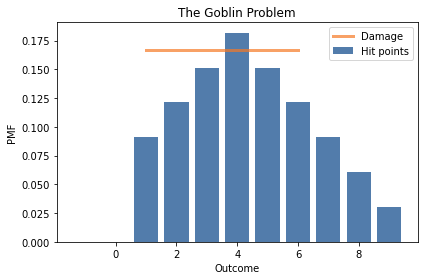

In [60]:
# Solution goes here

# Here's what the distributions look like
hp_after.bar(label='Hit points')
damage.plot(label='Damage', color='C1')
decorate_dice('The Goblin Problem')

In [61]:
# Solution goes here


# Here's the distribution of points the goblin has left
points_left = Pmf.sub_dist(hp_after, damage)

In [62]:
# Solution goes here

# And here's the probability the goblin is dead
points_left.prob_le(0)

0.4545454545454545

**Exercise:** Suppose I have a box with a 6-sided die, an 8-sided die, and a 12-sided die.
I choose one of the dice at random, roll it twice, multiply the outcomes, and report that the product is 12.
What is the probability that I chose the 8-sided die?

Hint: `Pmf` provides a function called `mul_dist` that takes two `Pmf` objects and returns a `Pmf` that represents the distribution of the product.

In [63]:
# Solution goes here

hypos = [6, 8, 12]
prior = Pmf(1, hypos)

In [64]:
# Solution goes here

# Here's the distribution of the product for the 4-sided die

d4 = make_die(4)
Pmf.mul_dist(d4, d4)

,probs
1,0.0625
2,0.1250
3,0.1250
4,0.1875
6,0.1250
8,0.1250
9,0.0625
12,0.1250
16,0.0625


In [65]:
# Solution goes here

# Here's the likelihood of getting a 12 for each die
likelihood = []

for sides in hypos:
    die = make_die(sides)
    pmf = Pmf.mul_dist(die, die)
    likelihood.append(pmf[12])
    
likelihood

[0.1111111111111111, 0.0625, 0.041666666666666664]

In [66]:
# Solution goes here

# And here's the update
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
6,0.516129
8,0.290323
12,0.193548


**Exercise:** *Betrayal at House on the Hill* is a strategy game in which characters with different attributes explore a haunted house.  Depending on their attributes, the characters roll different numbers of dice.  For example, if attempting a task that depends on knowledge, Professor Longfellow rolls 5 dice, Madame Zostra rolls 4, and Ox Bellows rolls 3.  Each die yields 0, 1, or 2 with equal probability.  

If a randomly chosen character attempts a task three times and rolls a total of 3 on the first attempt, 4 on the second, and 5 on the third, which character do you think it was?

In [67]:
# Solution goes here

die = Pmf(1/3, [0,1,2])
die

,probs
0,0.333333
1,0.333333
2,0.333333


In [68]:
# Solution goes here

pmfs = {}
pmfs['Bellows'] = add_dist_seq([die]*3)
pmfs['Zostra'] = add_dist_seq([die]*4)
pmfs['Longfellow'] = add_dist_seq([die]*5)

In [69]:
# Solution goes here

pmfs['Zostra'](4)

0.2345679012345679

In [70]:
# Solution goes here

pmfs['Zostra']([3,4,5]).prod()

0.00915247412224499

In [71]:
# Solution goes here


hypos = pmfs.keys()
prior = Pmf(1/3, hypos)
prior

,probs
Bellows,0.333333
Zostra,0.333333
Longfellow,0.333333


In [72]:
# Solution goes here

likelihood = prior.copy()

for hypo in hypos:
    likelihood[hypo] = pmfs[hypo]([3,4,5]).prod()

likelihood

,probs
Bellows,0.006401
Zostra,0.009152
Longfellow,0.004798


In [73]:
# Solution goes here

posterior = (prior * likelihood)
posterior.normalize()
posterior

,probs
Bellows,0.314534
Zostra,0.449704
Longfellow,0.235762


**Exercise:** There are 538 members of the United States Congress. Suppose we audit their investment portfolios and find that 312 of them out-perform the market.
Let's assume that an honest member of Congress has only a 50% chance of out-performing the market, but a dishonest member who trades on inside information has a 90% chance.  How many members of Congress are honest?

In [74]:
# Solution goes here

n = 538

table = pd.DataFrame()

for n_honest in range(0, n+1):
    n_dishonest = n - n_honest

    dist_honest = make_binomial(n_honest, 0.5)
    dist_dishonest = make_binomial(n_dishonest, 0.9)
    dist_total = Pmf.add_dist(dist_honest, dist_dishonest)    
    table[n_honest] = dist_total
    
table.shape

<ipython-input-74-5b9ecbd60ac2>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  table[n_honest] = dist_total


(539, 539)

In [75]:
# Solution goes here

data = 312
likelihood = table.loc[312]
len(likelihood)

539

In [76]:
# Solution goes here

hypos = np.arange(n+1)
prior = Pmf(1, hypos)
len(prior)

539

In [77]:
# Solution goes here

posterior = prior * likelihood
posterior.normalize()
posterior.mean()

431.48821145019957

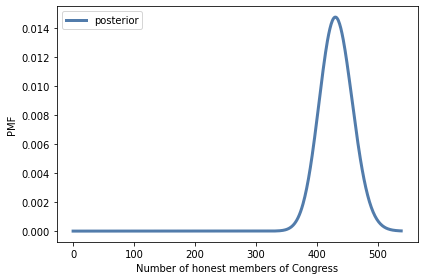

In [78]:
# Solution goes here

posterior.plot(label='posterior')
decorate(xlabel='Number of honest members of Congress',
         ylabel='PMF')

In [79]:
# Solution goes here

posterior.max_prob()

430

In [80]:
# Solution goes here

posterior.credible_interval(0.9)

array([388., 477.])